In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from keras.preprocessing import text, sequence
from keras.layers import Activation,Dense, Embedding, Dropout, LSTM, Input
from keras.models import  Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

Using TensorFlow backend.


In [3]:
df=pd.read_csv(r"C:\Users\Ramgopal.J\Desktop\NLP\my projs\disaster tweets\disas_train.csv" ,usecols = ["text","target"])

In [4]:
df.text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

C:\Users\Ramgopal.J\anaconda3\envs\mynlp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'tweets')

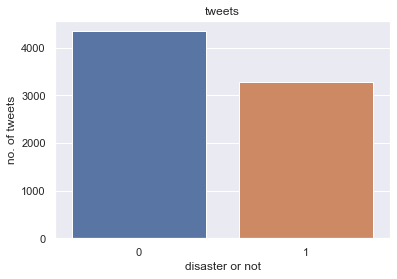

In [3]:
sns.set_theme(style='darkgrid')
sns.countplot(df.target)
plt.ylabel('no. of tweets')
plt.xlabel('disaster or not')
plt.title('tweets')

In [4]:
def clean(tweet):
    tweet=tweet.lower()
    tweet=re.sub(r"http\S+"," ",tweet)
    tweet= re.sub(r'\W'," ",tweet)  
    tweet=re.sub(r'[0-9]'," ",tweet)
    return tweet
cleaning=lambda x: clean(x)
df['text']=df['text'].apply(cleaning)

In [5]:
df

,text,target
0,our deeds are the reason of this earthquake m...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are ...,1
3,people receive wildfires evacuation or...,1
4,just got sent this photo from ruby alaska as ...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,aria_ahrary thetawniest the out of control w...,1
7610,m utc km s of volcano hawaii,1
7611,police investigating after an e bike collided ...,1


In [6]:
#stopwords
f=open(r"C:\Users\Ramgopal.J\Desktop\NLP\embeddings\stopwords.txt",encoding="utf-8")
content = f.read()
stopwords = content.split(",")
f.close()
stopwords=[i.replace('"',"").strip() for i in stopwords]

In [7]:
df['text']=df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [8]:
df

,text,target
0,deeds reason earthquake allah forgive,1
1,forest ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,photo ruby alaska smoke wildfires pours school,1
...,...,...
7608,giant cranes holding bridge collapse nearby homes,1
7609,aria_ahrary thetawniest control wild fires cal...,1
7610,utc volcano hawaii,1
7611,police investigating bike collided car portuga...,1


In [9]:
def get_lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

df['text'] = get_lemmatized_text(df['text'])

In [10]:
df

,text,target
0,deed reason earthquake allah forgive,1
1,forest ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,people receive wildfire evacuation order calif...,1
4,photo ruby alaska smoke wildfire pours school,1
...,...,...
7608,giant crane holding bridge collapse nearby home,1
7609,aria_ahrary thetawniest control wild fire cali...,1
7610,utc volcano hawaii,1
7611,police investigating bike collided car portuga...,1


In [11]:
x_train=df.text
y_train=df.target

no of words


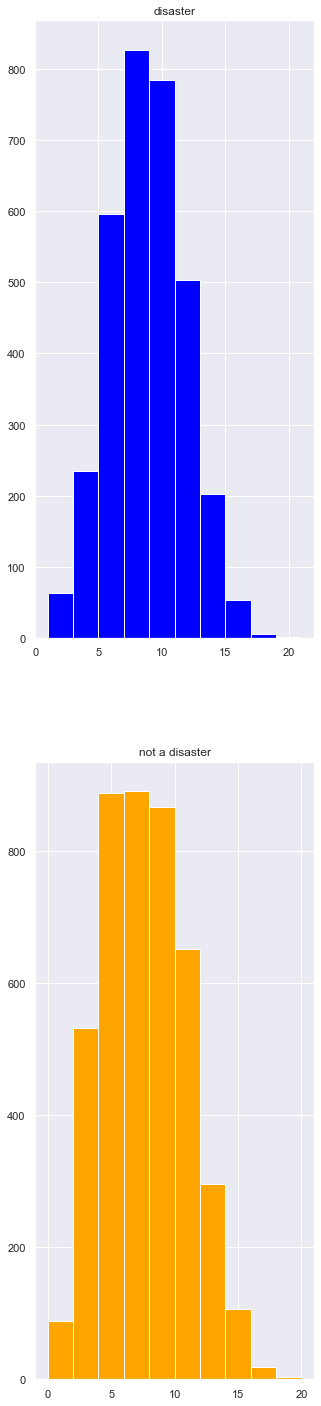

In [12]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(5,25))
train_len=df[df['target']==1]['text'].str.split().map(lambda x:len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('disaster')

train_len=df[df['target']==0]['text'].str.split().map(lambda x:len(x))
ax2.hist(train_len,color='orange')
ax2.set_title('not a disaster')
print('no of words')
plt.show()

In [13]:
max_len=30
max_words=10000
tok=text.Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences=tok.texts_to_sequences(x_train)
sequences_matrix=sequence.pad_sequences(sequences,maxlen=max_len,padding='post')

In [14]:
embedding_index=dict()
#f=open(r"C:\Users\Ramgopal.J\Documents\NLP\glove.840B.300d.gensim",encoding="Latin-1")
f1=open(r'C:\Users\Ramgopal.J\Desktop\NLP\embeddings\glove.6B.100d.txt',encoding="utf-8") #https://stackoverflow.com/questions/9233027/unicodedecodeerror-charmap-codec-cant-decode-byte-x-in-position-y-character
for line in f1:
    values=line.split()
    word=values[0]
    coefs=np.array(values[1:])
    embedding_index[word]=coefs
f1.close()
k=len(embedding_index)
print(f'Loaded {k} word vectors')

Loaded 400000 word vectors


In [15]:
vocab_size_train=len(tok.word_index)+1
embedding_matrix=np.zeros((vocab_size_train,100))
for word,i in tok.word_index.items():
    embedding_vector=embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [16]:
print(vocab_size_train)

14500


In [17]:
def RNN():
    inputs=Input(name='inputs',shape=[max_len])
    layer=Embedding(vocab_size_train,100,weights=[embedding_matrix],input_length=30,trainable=False)(inputs)
    layer=LSTM(64)(layer)
    layer=Dense(128)(layer)
    layer=Activation('relu')(layer)
    layer=Dropout(0.5)(layer)
    layer=Dense(64)(layer)
    layer=Activation('relu')(layer)
    layer=Dropout(0.5)(layer)
    layer=Dense(1)(layer)
    layer=Activation('sigmoid')(layer)
    model=Model(inputs=inputs,outputs=layer)
    return model

In [18]:
model=RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 100)           1450000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256

In [19]:
model.fit(sequences_matrix,y_train,batch_size=512,epochs=100,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.00001)])

Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 3s 415us/step - loss: 0.6838 - accuracy: 0.5800 - val_loss: 0.6515 - val_accuracy: 0.7104
Epoch 2/100
6090/6090 [==============================] - 2s 277us/step - loss: 0.5711 - accuracy: 0.7509 - val_loss: 0.4668 - val_accuracy: 0.8037
Epoch 3/100
6090/6090 [==============================] - 2s 277us/step - loss: 0.4973 - accuracy: 0.7847 - val_loss: 0.4531 - val_accuracy: 0.8083
Epoch 4/100
6090/6090 [==============================] - 2s 275us/step - loss: 0.4780 - accuracy: 0.7980 - val_loss: 0.4468 - val_accuracy: 0.8129
Epoch 5/100
6090/6090 [==============================] - 2s 280us/step - loss: 0.4578 - accuracy: 0.8049 - val_loss: 0.4375 - val_accuracy: 0.8135
Epoch 6/100
6090/6090 [==============================] - 2s 280us/step - loss: 0.4520 - accuracy: 0.8095 - val_loss: 0.4395 - val_accuracy: 0.8096


In [5]:
dt=pd.read_csv(r"C:\Users\Ramgopal.J\Desktop\NLP\my projs\disaster tweets\disas_test.csv")

In [21]:
dt.text=dt.text.apply(cleaning)
dt['text']=dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
dt['text'] = get_lemmatized_text(dt['text'])
X_test=dt.text

In [6]:
dt

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [22]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [23]:
Y_test = model.predict(test_sequences_matrix)


In [24]:
dt1=pd.DataFrame(dt.id)

In [25]:
dt1['target']=Y_test.round().astype(int)

In [26]:
dt1.to_csv('disas_submission6.csv', index=False)